In [1]:
import sys
import os

sys.path.append(os.path.abspath('..'))

In [2]:
from utils import get_cuda_info

get_cuda_info()

PyTorch version: 2.5.1+cu118
**********
_CUDA version: 
CUDA version:
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Wed_Oct_30_01:18:48_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.6, V12.6.85
Build cuda_12.6.r12.6/compiler.35059454_0

**********
CUDNN version: 90100
Available GPU devices: 1
Device Name: NVIDIA GeForce RTX 4070 Ti SUPER


## Wybór optymalnych punktów charakterystycznych

In [3]:
import numpy as np

LANDMARK_INDEXES = np.load(os.path.join('..', '..', 'data', 'landmarks', 'combined_selected_points_emotions.npy'))
REFERENCE_POINT_IDX = 0

### Wizualizacja wybranych punktów

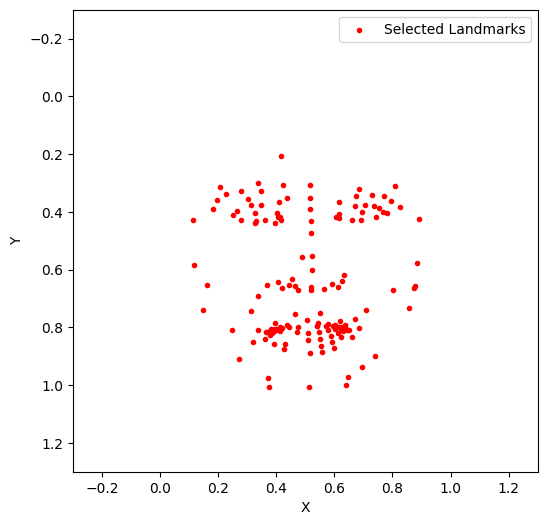

In [4]:
from utils import visualize_landmarks

visualize_landmarks(LANDMARK_INDEXES)

### Zdobycie danych

In [5]:
from utils import load_data, convert_landmarks_to_distances

all_data, all_labels = load_data('miami_deception')
all_data = convert_landmarks_to_distances(all_data, LANDMARK_INDEXES, REFERENCE_POINT_IDX, normalize=True)

## Preprocessing danych

In [6]:
from utils import preprocess_data

X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(all_data, all_labels, binarize_labels=False)

In [7]:
print(X_train.shape)
print(y_train.shape)

torch.Size([224, 1679, 154])
torch.Size([224])


# MODEL TORCH

## Zbudowanie modelu ekstrakcji cech

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [9]:
class LieClassifier(nn.Module):
    def __init__(self, input_distances):
        super(LieClassifier, self).__init__()
        
        # Spatial feature extraction (changed in_channels to 1)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        # Calculate LSTM input dimension
        self.conv_output_size = 64 * (input_distances // 4)  # After two poolings
        
        # Temporal feature extraction
        self.lstm = nn.LSTM(input_size=self.conv_output_size, hidden_size=128,
                          batch_first=True, bidirectional=True)
        
        # Classification head
        self.fc1 = nn.Linear(256, 64)  # 128*2 for bidirectional
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 1)
        
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0.1)

    def forward(self, x):
        # x shape: (batch_size, frames, distances)
        batch_size, frames, distances = x.shape
        
        # Reshape for Conv1D: (batch*frames, 1, distances)
        x = x.view(-1, 1, distances)
        
        # Spatial features
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        # Prepare for LSTM
        x = x.view(batch_size, frames, -1)
        
        # Temporal features
        x, _ = self.lstm(x)
        
        # Classification
        x = x[:, -1, :]  # Last timestep
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))

        return x

In [14]:
from torch.optim import Adam

model = LieClassifier(input_distances=len(LANDMARK_INDEXES))
pos_weight = torch.tensor([2.0]).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = Adam(model.parameters(), lr=1e-4)

### Diagnostyka

In [ ]:
from utils.model_functions import overfit_model

model_diag = LieClassifier(input_distances=len(LANDMARK_INDEXES))
pos_weight_diag = torch.tensor([2.0]).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
criterion_diag = nn.BCEWithLogitsLoss(pos_weight=pos_weight_diag)
optimizer_diag = Adam(model.parameters(), lr=1e-3)

overfit_model(model_diag, criterion_diag, optimizer_diag, X_train, y_train, prediction_threshold=0.7)


=== Debug Mode ===
Input shape: torch.Size([32, 1679, 154])
Label distribution: 0.56 (1s)

Step 0:
Loss: 0.9612
Accuracy: 43.75%
Predictions (5 samples): [0.6574 0.6504 0.6455 0.6534 0.6537]
Labels (5 samples): [1. 0. 0. 0. 1.]
Param conv1.weight: shape (32, 1, 3) | grad norm: 0.000000
Param conv1.bias: shape (32,) | grad norm: 0.021902
Param conv2.weight: shape (64, 32, 3) | grad norm: 0.028837
Param conv2.bias: shape (64,) | grad norm: 0.029633
Param lstm.weight_ih_l0: shape (512, 2432) | grad norm: 0.174707
Param lstm.weight_hh_l0: shape (512, 128) | grad norm: 0.047296
Param lstm.bias_ih_l0: shape (512,) | grad norm: 0.023743
Param lstm.bias_hh_l0: shape (512,) | grad norm: 0.023743
Param lstm.weight_ih_l0_reverse: shape (512, 2432) | grad norm: 0.082762
Param lstm.weight_hh_l0_reverse: shape (512, 128) | grad norm: 0.000000
Param lstm.bias_ih_l0_reverse: shape (512,) | grad norm: 0.011247
Param lstm.bias_hh_l0_reverse: shape (512,) | grad norm: 0.011247
Param fc1.weight: shape (6

KeyboardInterrupt: 

## Trening modelu

In [13]:
from torch.utils.tensorboard import SummaryWriter

RUNS_FOLDER_PATH = os.path.abspath('runs')
writer_path = os.path.join('runs', 'torch_lstm', 'lie_classifier_landmark_distance_normalized')
writer = SummaryWriter(writer_path)

In [15]:
from utils.model_functions import train_torch_model_binary

train_torch_model_binary(model, criterion, optimizer, X_train, y_train, X_val, y_val, writer=writer, prediction_threshold=0.7)


                                          EPOCH STATISTICS                                          
Epoch       : 1
----------------------------------------------------------------------------------------------------
                     TRAINING                                         VALIDATION                    
----------------------------------------------------------------------------------------------------
Loss        : 6.6605                                    Loss        : 1.9775
Accuracy    : 0.4732                                    Accuracy    : 0.6458
Precision   : 0.2366                                    Precision   : 0.3229
Recall      : 0.5000                                    Recall      : 0.5000
F1 Score    : 0.3212                                    F1 Score    : 0.3924
----------------------------------------------------------------------------------------------------
                                          VALIDATION EXTRA                                   

## Ewaluacja modelu

In [17]:
from utils.model_functions import eval_torch_model_binary

eval_torch_model_binary(model, criterion, X_test, y_test)


                                          EPOCH STATISTICS                                          
Epoch       : 1
----------------------------------------------------------------------------------------------------
                                             VALIDATION                                             
----------------------------------------------------------------------------------------------------
Loss        : 1.8864
Accuracy    : 0.5208
Precision   : 0.2604
Recall      : 0.5000
F1 Score    : 0.3425
----------------------------------------------------------------------------------------------------
                                          VALIDATION EXTRA                                          
TP Rate     : 1.0000                                    FP Rate     : 1.0000



## Model Seglearn

In [12]:
from xgboost import XGBClassifier
from seglearn.pipe import Pype
from seglearn.transform import FeatureRep, Segment

In [25]:
X_train_np = X_train.numpy()
X_val_np = X_val.numpy()
X_test_np = X_test.numpy()
y_train_np = y_train.numpy()
y_val_np = y_val.numpy()
y_test_np = y_test.numpy()

In [26]:
X_train_np.shape

(224, 1679, 154)

In [27]:
y_train_np.shape

(224,)

### Budowa modelu

In [29]:
pipe = Pype([
    ("segment", Segment(width=20, step=10)),  # Segmentacja sekwencji
    ("features", FeatureRep()),              # Ekstrakcja cech
    ("xgb", XGBClassifier(
        eval_metric='logloss',
        n_estimators=200
    ))
])

### Trening modelu

In [30]:
pipe.fit(X_train_np, y_train_np)

Pype(steps=[('segment', Segment(overlap=None, step=10, width=20)),
            ('features',
             FeatureRep(features={'abs_energy': <function abs_energy at 0x0000011B25FDCA40>,
                                  'kurt': <function kurt at 0x0000011B25FDCF40>,
                                  'max': <function maximum at 0x0000011B25FDCE00>,
                                  'mean': <function mean at 0x0000011B25FDC680>,
                                  'median': <function median at 0x0000011B25FDC720>,
                                  'min': <function minimum at 0x...
                           gamma=None, grow_policy=None, importance_type=None,
                           interaction_constraints=None, learning_rate=None,
                           max_bin=None, max_cat_threshold=None,
                           max_cat_to_onehot=None, max_delta_step=None,
                           max_depth=None, max_leaves=None,
                           min_child_weight=None, missing=nan,
                           monotone_constraints=None, multi_strategy=None,
                           n_estimators=200, n_jobs=None,
                           num_parallel_tree=None, random_state=None, ...))])

### Ewaluacja modelu

In [31]:
val_accuracy = pipe.score(X_val_np, y_val_np)
test_accuracy = pipe.score(X_test_np, y_test_np)

print(f"Dokładność na zbiorze walidacyjnym: {val_accuracy:.2f}")
print(f"Dokładność na zbiorze testowym: {test_accuracy:.2f}")

Dokładność na zbiorze walidacyjnym: 0.43
Dokładność na zbiorze testowym: 0.50


# TODYNET

### Przygotowanie danych

In [10]:
X_train_np = X_train.numpy()
X_val_np = X_val.numpy()
X_test_np = X_test.numpy()
y_train_np = y_train.numpy()
y_val_np = y_val.numpy()
y_test_np = y_test.numpy()

In [11]:
TodyNet_DATA_PATH = os.path.join("..", "..", "src", "external", "TodyNet", "data", "UCR", "MIAMI_NORMALIZED")

os.makedirs(TodyNet_DATA_PATH, exist_ok=True)

In [12]:
import torch

X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32).unsqueeze(1)  # adding channel dimension
X_val_tensor = torch.tensor(X_val_np, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).unsqueeze(1)

# Save the data in PyTorch (.pt) format
torch.save(X_train_tensor, os.path.join(TodyNet_DATA_PATH, 'X_train.pt'))
torch.save(X_val_tensor, os.path.join(TodyNet_DATA_PATH, 'X_valid.pt'))
torch.save(X_test_tensor, os.path.join(TodyNet_DATA_PATH, 'X.pt'))

# Save the labels in PyTorch (.pt) format
torch.save(y_train.long(), os.path.join(TodyNet_DATA_PATH, 'y_train.pt'))
torch.save(y_val.long(), os.path.join(TodyNet_DATA_PATH, 'y_valid.pt'))
torch.save(y_test.long(), os.path.join(TodyNet_DATA_PATH, 'y.pt'))

### Trening modelu (zmniejszone parametry ze względu na wielkość modelu)

In [ ]:
# cd .\src\external\TodyNet\src\ & python train.py --dataset='MIAMI_NORMALIZED' --num_layers 1 --in_dim 16 --hidden_dim 16 --out_dim 16 --pool_ratio 0.0 --kern_size "3" --groups 1

## Wynik po 120 epokach:

TRAIN, epoch 120, loss 0.3350060475724084, acc tensor([89.2857], device='cuda:0')

VAL, loss 1.0498636364936829, acc tensor([45.8333], device='cuda:0')